# Dissertation

In [2]:
#Importing libararies

import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from keras_tuner.tuners import BayesianOptimization
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
from bs4 import BeautifulSoup
import datetime, time
import requests
import os.path
from os import path

### Data acquisition

In [154]:
# Provide the correct path to your CSV file
csv_file_path = 'SNP500_data.csv'

# Read the CSV file into a dataframe
SNP500 = pd.read_csv(csv_file_path)

# Now you can use the imported_df dataframe in your program
SNP500.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price,Stock Name
0,102.87,70.0,0.009096,0.0609,0.2177,0.0423,33.17,MMM
1,102.87,94.0,0.009096,0.0609,0.2177,0.0423,8.93,MMM
2,102.87,95.0,0.009096,0.0609,0.2177,0.0423,7.98,MMM
3,102.87,96.0,0.009096,0.0609,0.2177,0.0423,6.95,MMM
4,102.87,97.0,0.009096,0.0609,0.2177,0.0423,6.05,MMM


In [155]:
SNP500.describe()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
count,41796.000000,41796.000000,41796.000000,41796.000000,41796.000000,4.179600e+04,41796.000000
mean,270.960154,209.745493,0.488636,0.015856,0.267977,4.230000e-02,64.936511
std,429.501470,354.176779,0.542330,0.017404,0.085970,1.803440e-14,123.281248
min,9.580000,0.350000,0.008546,0.000000,0.000000,4.230000e-02,0.000000
25%,79.250000,57.500000,0.066041,0.000000,0.204900,4.230000e-02,9.850000
50%,146.170000,110.000000,0.296684,0.011300,0.252400,4.230000e-02,27.650000
75%,302.670000,220.000000,0.813475,0.025900,0.325300,4.230000e-02,70.250000
max,3064.260000,3060.000000,2.557600,0.089800,0.596300,4.230000e-02,2285.000000


In [156]:
SNP500 = SNP500.drop(columns=['Dividends', 'Stock Name'])
SNP500 = SNP500[SNP500['Call Price'] > 0]

In [157]:
SNP500.head()

,Stock Price,Strike Price,Maturity,Volatility,Risk-free,Call Price
0,102.87,70.0,0.009096,0.2177,0.0423,33.17
1,102.87,94.0,0.009096,0.2177,0.0423,8.93
2,102.87,95.0,0.009096,0.2177,0.0423,7.98
3,102.87,96.0,0.009096,0.2177,0.0423,6.95
4,102.87,97.0,0.009096,0.2177,0.0423,6.05


### Data Simulation

In [8]:
# Geometric Brownian Motion (GBM) values generated for stock prices

def GBM(x0,N,r,sigma,T):
    # Generate time steps (t)
    dt = T / N
    t = np.linspace(0, T, N + 1)

    # Generate GBM sample
    np.random.seed(1)
    W = np.random.standard_normal(size=N)
    W = np.insert(W, 0, 0.0)
    W = np.cumsum(W) * np.sqrt(dt)
    S = x0 * np.exp((r - 0.5 * sigma ** 2) * t + sigma * W)
    
    return S

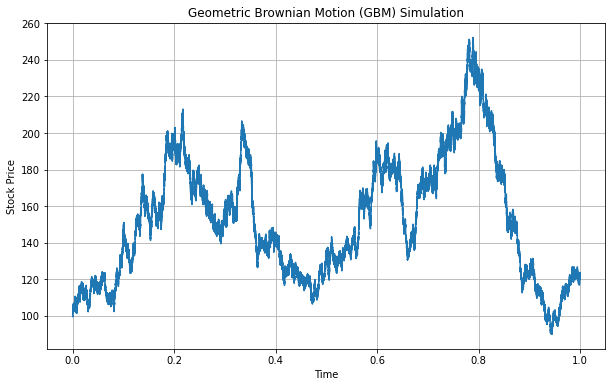

In [9]:
#Generate stock prices using GBM 

s = 100 #initial stock price
N = 1000000 #step size
mu = 0.01 #drift rate
sigma = 0.8 #volatility
T = 1 #Time horizon

S = GBM(s, N, mu, sigma, T)
t = np.linspace(0, T, N + 1)

plt.figure(figsize=(10, 6))
plt.plot(t, S)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Geometric Brownian Motion (GBM) Simulation')
plt.grid(True)
plt.show()

### Black Scholes Model

In [10]:
#Black-Scholes call value generator

def BSM(S, K, r, sigma, t=0, T=1):
    d1 = (np.log(S/K) + (r + (sigma**2)/2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return (S * norm.cdf(d1)) - (K * np.exp(-r * (T - t)) * norm.cdf(d2))

In [11]:
# Generate Dataset using Black-scholes and GBM

s = 100 #initial stock price
N = 1000000 #step size
mu = 0.01 #drift rate
sigma = 0.8 #volatility
T = 1 #Time horizon

np.random.seed(1)
mu = 0.01
sample = GBM(s, N, mu, sigma, T)
mydata = {}
mydata['Stock'] = sample
mydata['Strike'] = sample * np.random.uniform(low=0.4, high=1, size=len(sample)) #in-the money strike prices
mydata['Time'] = np.random.uniform(low=0, high=1, size=len(sample))
mydata['sigma'] = np.random.uniform(low=0.1, high=0.8, size=len(sample))
mydata['r'] = np.random.uniform(low=0.01, high=0.05, size=len(sample))
mydata['BS'] = BSM(S=mydata['Stock'], t=0, T=mydata['Time'], r=mydata['r'], K=mydata['Strike'], sigma=mydata['sigma'])

mydata = pd.DataFrame(mydata)  # Converts dictionary to data frame
mydata.head()

,Stock,Strike,Time,sigma,r,BS
0,100.000000,81.335226,0.835218,0.452288,0.013821,26.540123
1,100.130001,63.020201,0.840251,0.496220,0.038249,41.556753
2,100.080978,44.071530,0.045967,0.231775,0.037707,56.085770
3,100.038668,96.183153,0.203914,0.353225,0.037199,8.770495
4,99.952803,50.052237,0.859039,0.277178,0.045176,51.817431


In [201]:
mydata

,Stock,Strike,Time,sigma,r,BS
0,100.000000,81.335226,0.835218,0.452288,0.013821,26.540123
1,100.130001,63.020201,0.840251,0.496220,0.038249,41.556753
2,100.080978,44.071530,0.045967,0.231775,0.037707,56.085770
3,100.038668,96.183153,0.203914,0.353225,0.037199,8.770495
4,99.952803,50.052237,0.859039,0.277178,0.045176,51.817431
...,...,...,...,...,...,...
999996,123.443057,58.716275,0.056995,0.724450,0.022186,64.801008
999997,123.456879,118.341661,0.668871,0.193359,0.029663,11.840212
999998,123.397975,90.816288,0.601275,0.432714,0.042343,37.818713
999999,123.515076,94.588372,0.071274,0.111500,0.044823,29.228404


### EDA (Explaratory Data Analysis)

In [12]:
mydata.describe().apply(lambda x: x.round(2))

,Stock,Strike,Time,sigma,r,BS
count,1000001.00,1000001.00,1000001.00,1000001.00,1000001.00,1000001.00
mean,152.33,106.62,0.50,0.45,0.03,52.34
std,33.45,35.75,0.29,0.20,0.01,25.87
min,90.08,36.35,0.00,0.10,0.01,0.38
25%,123.53,79.51,0.25,0.28,0.02,32.31
50%,148.68,101.91,0.50,0.45,0.03,49.80
75%,176.81,128.92,0.75,0.63,0.04,69.19
max,252.21,250.33,1.00,0.80,0.05,155.24


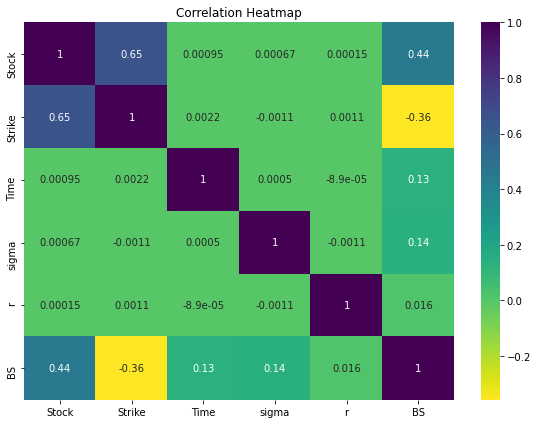

In [13]:
# Correlation matrix

correlation_matrix = mydata.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis_r')
plt.title('Correlation Heatmap')
plt.xticks()
plt.tight_layout()
plt.show()

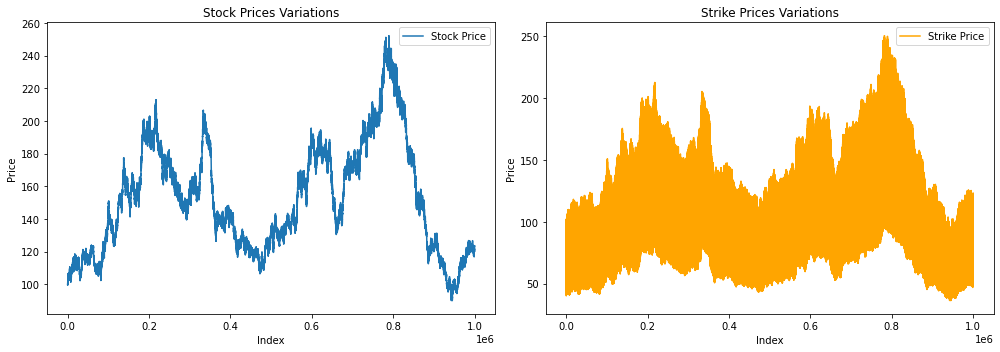

In [14]:
# Stock v/s Strike
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

#Stock Prices Variations
axes[0].plot(mydata['Stock'], label='Stock Price')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Price')
axes[0].set_title('Stock Prices Variations')
axes[0].legend()

#Strike Prices Variations
axes[1].plot(mydata['Strike'], label='Strike Price', color='orange')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Price')
axes[1].set_title('Strike Prices Variations')
axes[1].legend()

plt.tight_layout()
plt.show()


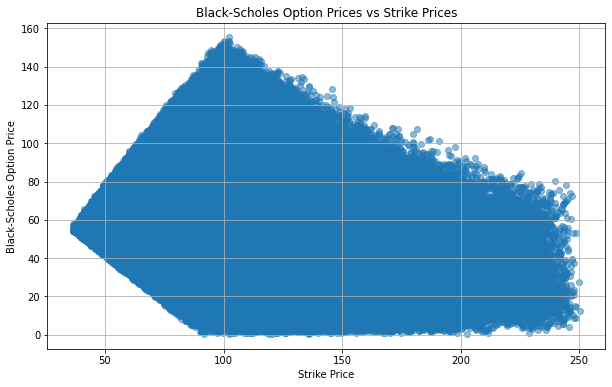

In [15]:
# BSM Call prices v/s Strike price
plt.figure(figsize=(10, 6))
plt.scatter(mydata['Strike'], mydata['BS'], alpha=0.5)
plt.xlabel('Strike Price')
plt.ylabel('Black-Scholes Option Price')
plt.title('Black-Scholes Option Prices vs Strike Prices')

# Show the plot
plt.grid(True)
plt.show()


## Training Black-Scholes formula on Neural Network

In [39]:
X = mydata.drop('BS', axis=1).values
y = mydata['BS'].values

In [40]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1)

In [202]:
X_train.shape[1]

5

### Keras Models

### 1. ANN (Multilayer Perceptron)

In [19]:
# Build the MLPRegressor model
model_mlp = Sequential([
    Dense(units=20, activation='relu', input_dim=X_train.shape[1]),
    Dense(units=20, activation='relu'),
    Dense(units=1)  # Output layer
])

# Compile the model
model_mlp.compile(optimizer='adam', loss='mean_squared_error')

# Print model summary
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                120       
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 561
Trainable params: 561
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Train the model
history = model_mlp.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
10000/10000 [==============================] - 19s 2ms/step - loss: 109.6138 - val_loss: 0.9770
Epoch 2/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.6704 - val_loss: 0.5494
Epoch 3/20
10000/10000 [==============================] - 19s 2ms/step - loss: 0.4879 - val_loss: 0.4184
Epoch 4/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.4226 - val_loss: 0.3888
Epoch 5/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3977 - val_loss: 0.3647
Epoch 6/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3844 - val_loss: 0.3712
Epoch 7/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3748 - val_loss: 0.3578
Epoch 8/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3653 - val_loss: 0.3568
Epoch 9/20
10000/10000 [==============================] - 18s 2ms/step - loss: 0.3583 - val_loss: 0.3501
Epoch 10/20
10000/10000 [============================

In [21]:
# Evaluate the model on the test set
y_pred_mlp = model_mlp.predict(X_test)

6251/6251 [==============================] - 8s 1ms/step


In [22]:
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)

print("Mean Squared Error:", mse_mlp)
print("R-squared:", mse_mlp)
print("Mean Absolute Error:", mse_mlp)

Mean Squared Error: 0.24799603781596258
R-squared: 0.24799603781596258
Mean Absolute Error: 0.24799603781596258


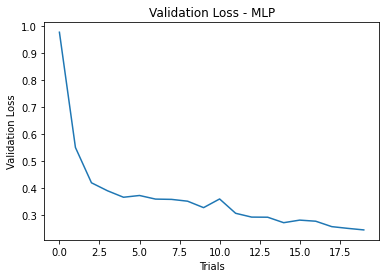

In [23]:
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - MLP')
plt.show()

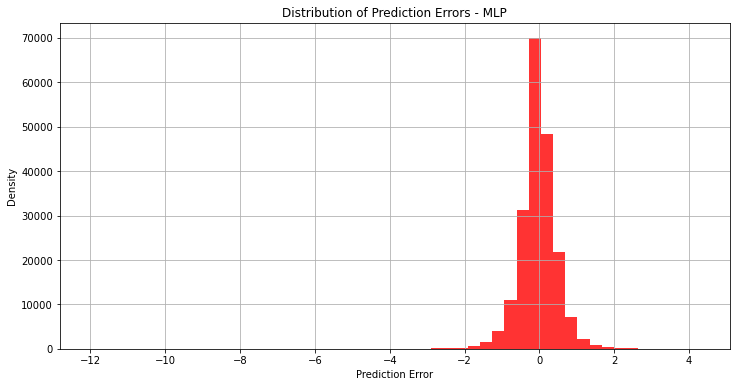

In [24]:
#Pricing error

errors = y_test - y_pred_mlp.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, color='red', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors - MLP')
plt.grid(True)
plt.show()

### LSTM Model

In [42]:
# Reshape input data for LSTM
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [43]:
# Define the LSTM model
model_lstm = Sequential([
    LSTM(units=20, activation='relu', input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    LSTM(units=20, activation='relu', return_sequences=False),Dense(units=1)
])

# Compile the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 5, 20)             1760      
                                                                 
 lstm_7 (LSTM)               (None, 20)                3280      
                                                                 
 dense_6 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,061
Trainable params: 5,061
Non-trainable params: 0
_________________________________________________________________


In [44]:
# Train the model
history = model_lstm.fit(X_train, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
10000/10000 [==============================] - 56s 5ms/step - loss: 72.6248 - val_loss: 2.5739
Epoch 2/20
10000/10000 [==============================] - 52s 5ms/step - loss: 1.7531 - val_loss: 1.9993
Epoch 3/20
10000/10000 [==============================] - 54s 5ms/step - loss: 1.2362 - val_loss: 0.8563
Epoch 4/20
10000/10000 [==============================] - 60s 6ms/step - loss: 1.0149 - val_loss: 0.6882
Epoch 5/20
10000/10000 [==============================] - 53s 5ms/step - loss: 0.8806 - val_loss: 0.6821
Epoch 6/20
10000/10000 [==============================] - 53s 5ms/step - loss: 0.7402 - val_loss: 0.7433
Epoch 7/20
10000/10000 [==============================] - 53s 5ms/step - loss: 0.5637 - val_loss: 0.6168
Epoch 8/20
10000/10000 [==============================] - 55s 6ms/step - loss: 0.4645 - val_loss: 0.2912
Epoch 9/20
10000/10000 [==============================] - 59s 6ms/step - loss: 0.3695 - val_loss: 0.2475
Epoch 10/20
10000/10000 [=============================

In [45]:
# Evaluate the model on the test set
y_pred_lstm = model_lstm.predict(X_test)

6251/6251 [==============================] - 15s 2ms/step


In [46]:
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print("Mean Squared Error:", mse_lstm)
print("R-squared:", r2_lstm)
print("Mean Absolute Error:", mae_lstm)

Mean Squared Error: 0.0317121350662811
R-squared: 0.9999524621685604
Mean Absolute Error: 0.1330638874980352


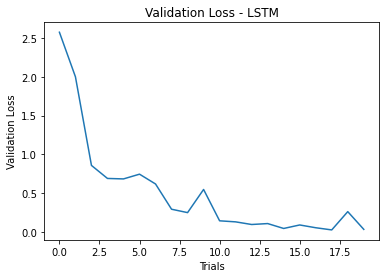

In [47]:
#lSTM Validation loss

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - LSTM')
plt.show()

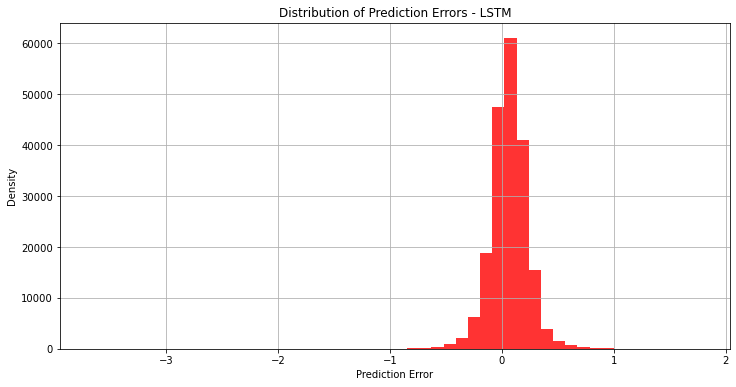

In [48]:
#Pricing error

errors_lstm = y_test - y_pred_lstm.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_lstm, bins=50, color='red', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors - LSTM')
plt.grid(True)
plt.show()

### GRU Model

In [49]:
# Create a Sequential model
model_GRU = Sequential([
    GRU(units=20, activation='relu', input_shape=(X_train_reshaped.shape[1], 1), return_sequences=True),
    Dense(units=20, activation='relu'),
    GRU(units=20, activation='relu', return_sequences=False),
    Dense(units=1)  # Output layer
])

# Compile the model
model_GRU.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model_GRU.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 5, 20)             1380      
                                                                 
 dense_7 (Dense)             (None, 5, 20)             420       
                                                                 
 gru_1 (GRU)                 (None, 20)                2520      
                                                                 
 dense_8 (Dense)             (None, 1)                 21        
                                                                 
Total params: 4,341
Trainable params: 4,341
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Train the model with validation split
history = model_GRU.fit(X_train_reshaped, 
                    y_train, 
                    epochs=20, 
                    batch_size=64, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

Epoch 1/20
10000/10000 [==============================] - 54s 5ms/step - loss: 96.8604 - val_loss: 0.9128
Epoch 2/20
10000/10000 [==============================] - 59s 6ms/step - loss: 0.5295 - val_loss: 0.3305
Epoch 3/20
10000/10000 [==============================] - 60s 6ms/step - loss: 0.2851 - val_loss: 0.1952
Epoch 4/20
10000/10000 [==============================] - 57s 6ms/step - loss: 0.2054 - val_loss: 0.1301
Epoch 5/20
10000/10000 [==============================] - 52s 5ms/step - loss: 0.1649 - val_loss: 0.0790
Epoch 6/20
10000/10000 [==============================] - 52s 5ms/step - loss: 0.1376 - val_loss: 0.0515
Epoch 7/20
10000/10000 [==============================] - 52s 5ms/step - loss: 0.1137 - val_loss: 0.0439
Epoch 8/20
10000/10000 [==============================] - 52s 5ms/step - loss: 0.0982 - val_loss: 0.0440
Epoch 9/20
10000/10000 [==============================] - 56s 6ms/step - loss: 0.0861 - val_loss: 0.0526
Epoch 10/20
10000/10000 [=============================

In [51]:
# Evaluate the model on the test set
y_pred_gru = model_GRU.predict(X_test)

6251/6251 [==============================] - 15s 2ms/step


In [52]:
mse_gru = mean_squared_error(y_test, y_pred_gru)
r2_gru = r2_score(y_test, y_pred_gru)
mae_gru = mean_absolute_error(y_test, y_pred_gru)

print("Mean Squared Error:", mse_gru)
print("R-squared:", r2_gru)
print("Mean Absolute Error:", mae_gru)

Mean Squared Error: 0.014823461955938264
R-squared: 0.999977779003705
Mean Absolute Error: 0.09261748901058144


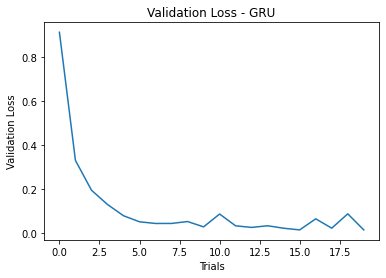

In [53]:
#GRU Validation loss

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - GRU')
plt.show()

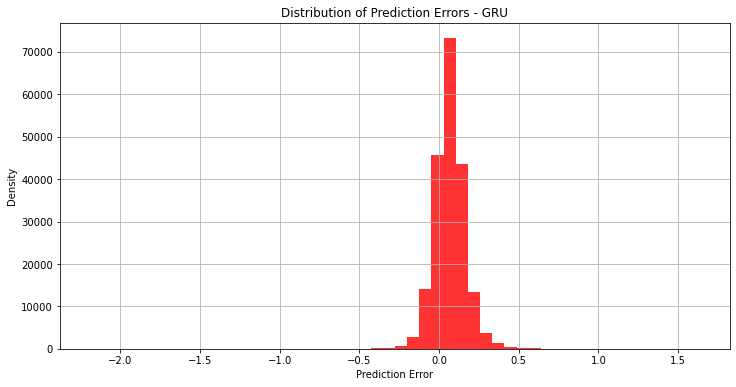

In [54]:
#Pricing error

errors_gru = y_test - y_pred_gru.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_gru, bins=50, color='red', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors - GRU')
plt.grid(True)
plt.show()

## Sci-Kit Model

### Multilayer Perceptron

In [114]:
mlp = MLPRegressor(hidden_layer_sizes=(20,20),
                   solver='adam',
                   batch_size=64,
                   learning_rate='constant',
                   verbose=True,
                   max_iter=20,
                  ) 

In [56]:
mlp.fit(X_train, y_train)
y_pred_mlp2 = mlp.predict(X_test)

Iteration 1, loss = 54.35447606
Iteration 2, loss = 0.38890823
Iteration 3, loss = 0.25761478
Iteration 4, loss = 0.20890135
Iteration 5, loss = 0.15650373
Iteration 6, loss = 0.12697780
Iteration 7, loss = 0.10973830
Iteration 8, loss = 0.10045963
Iteration 9, loss = 0.09705409
Iteration 10, loss = 0.09600369
Iteration 11, loss = 0.09251063
Iteration 12, loss = 0.08721629
Iteration 13, loss = 0.08376197
Iteration 14, loss = 0.07942875
Iteration 15, loss = 0.07545413
Iteration 16, loss = 0.07278131
Iteration 17, loss = 0.07091509
Iteration 18, loss = 0.06914620
Iteration 19, loss = 0.06786874
Iteration 20, loss = 0.06642802


C:\Users\Deepak\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [57]:
mse_mlp2 = mean_squared_error(y_test, y_pred_mlp2)
r2_mlp2 = r2_score(y_test, y_pred_mlp2)
mae_mlp2 = mean_absolute_error(y_test, y_pred_mlp2)

# Print the scores
print("Mean Squared Error (MSE):", mse_mlp2)
print("R-squared (R2):", r2_mlp2)
print("Mean Absolute Error (MAE):", mae_mlp2)

Mean Squared Error (MSE): 0.12500842049789987
R-squared (R2): 0.9998126070915835
Mean Absolute Error (MAE): 0.2595130604223345


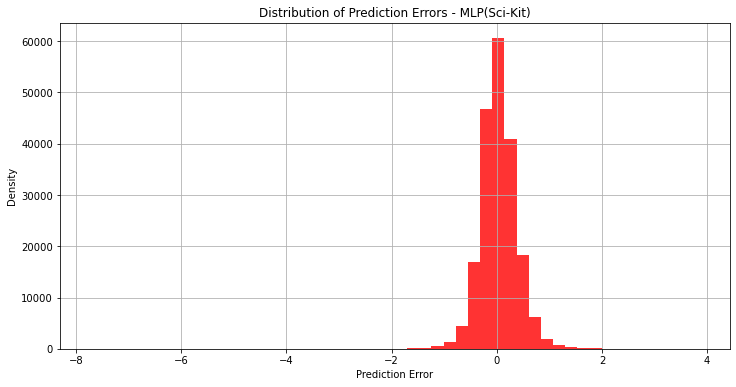

In [58]:
#Pricing error

errors_gru = y_test - y_pred_mlp2 #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_gru, bins=50, color='red', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Prediction Errors - MLP(Sci-Kit)')
plt.grid(True)
plt.show()

### Metrics Comparison

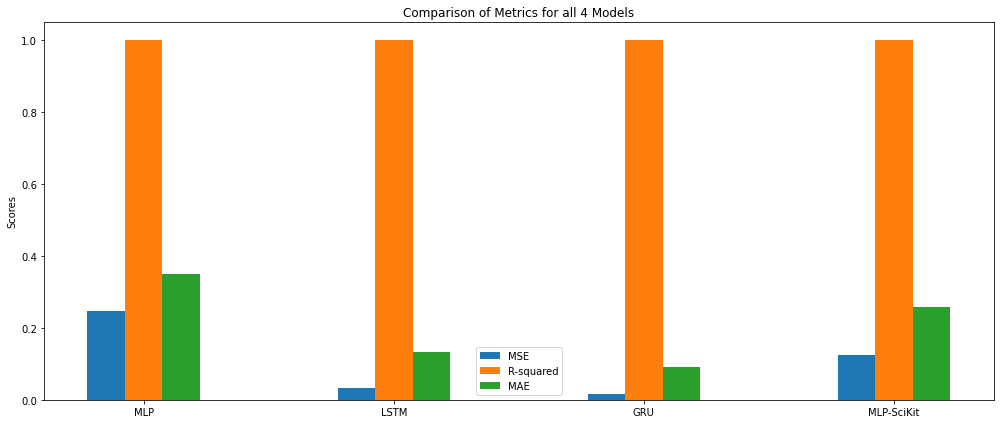

In [204]:
types = ['MLP', 'LSTM', 'GRU', 'MLP-SciKit']
mse_values = [mse_mlp, mse_lstm, mse_gru, mse_mlp2]  
r2_values = [r2_mlp, r2_lstm, r2_gru, r2_mlp2]  
mae_values = [mae_mlp, mae_lstm, mae_gru, mae_mlp2]

x = np.arange(len(types))
width = 0.15 #Bar width

plt.figure(figsize=(14, 6))
ax = plt.gca()

# Create grouped bar chart
ax.bar(x - width, mse_values, width, label='MSE')
ax.bar(x, r2_values, width, label='R-squared')
ax.bar(x + width, mae_values, width, label='MAE')

ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics for all 4 Models')
ax.set_xticks(x)
ax.set_xticklabels(types)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [60]:
Metrics = {
    'Type': types,
    'MSE': mse_values,
    'R2': r2_values,
    'MAE': mae_values
}

Metrics_df = pd.DataFrame(Metrics)
Metrics_df

,Type,MSE,R2,MAE
0,MLP,0.247996,0.999628,0.350771
1,LSTM,0.031712,0.999952,0.133064
2,GRU,0.014823,0.999978,0.092617
3,MLP-SciKit,0.125008,0.999813,0.259513


## Scatter plot of GRU model

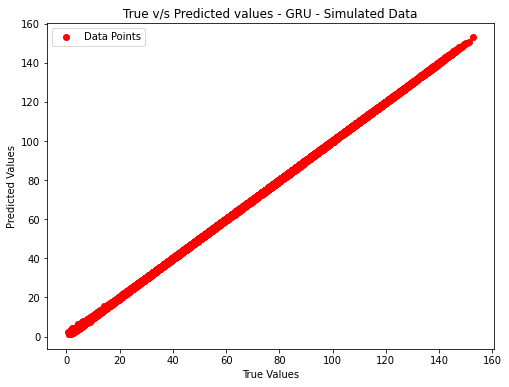

In [205]:
# Create a scatter plot to visualize True and Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gru.flatten(), color='red', label='Data Points')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True v/s Predicted values - GRU - Simulated Data')
plt.legend()
plt.show()

## Apply GRU model to predict real-world call prices

In [158]:
SNP500.rename(columns={
    'Stock Price': 'Stock',
    'Strike Price': 'Strike',
    'Maturity': 'Time',
    'Volatility': 'sigma',
    'Risk-free': 'r',
}, inplace=True)

In [159]:
X_actual = SNP500.drop('Call Price', axis=1).values
y_actual = SNP500['Call Price'].values

In [160]:
X_data = scaler.fit_transform(X_actual)

In [161]:
# Evaluate the model on the test set
y_pred_actual = model_GRU.predict(X_data)

mse_actual = mean_squared_error(y_actual, y_pred_actual)
r2_actual = r2_score(y_actual, y_pred_actual)
mae_actual = mean_absolute_error(y_actual, y_pred_actual)

# Print the scores
print("Mean Squared Error (MSE):", mse_actual)
print("R-squared (R2):", r2_actual)
print("Mean Absolute Error (MAE):", mae_actual)

1281/1281 [==============================] - 5s 4ms/step
Mean Squared Error (MSE): 14398.91154987027
R-squared (R2): 0.06599036945293968
Mean Absolute Error (MAE): 58.87092099420665


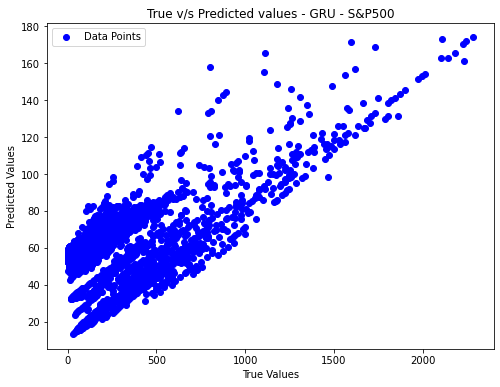

In [207]:
# Create a scatter plot to visualize True and Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_actual, y_pred_actual.flatten(), color='blue', label='Data Points')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True v/s Predicted values - GRU - S&P500')
plt.legend()
plt.show()

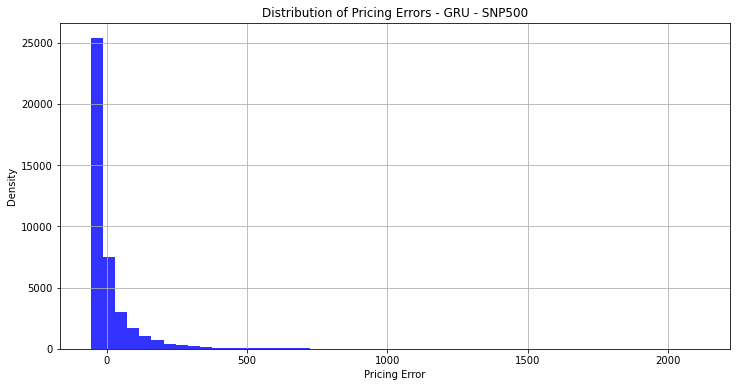

In [211]:
#Pricing error

errors_gru_snp500 = y_actual - y_pred_actual.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_gru_snp500, bins=50, color='blue', alpha=0.8)
plt.xlabel('Pricing Error')
plt.ylabel('Density')
plt.title('Distribution of Pricing Errors - GRU - SNP500')
plt.grid(True)
plt.show()

## Train Real-World data for Black-Scholes

In [163]:
#Create Black-Scholes values for real-world data

SNP500['BS-Real'] = BSM(SNP500['Stock'], SNP500['Strike'], SNP500['r'], SNP500['sigma'], T=SNP500['Time'])

In [164]:
SNP500

,Stock,Strike,Time,sigma,r,Call Price,BS-Real
0,102.87,70.0,0.009096,0.2177,0.0423,33.17,32.896927
1,102.87,94.0,0.009096,0.2177,0.0423,8.93,8.906162
2,102.87,95.0,0.009096,0.2177,0.0423,7.98,7.906572
3,102.87,96.0,0.009096,0.2177,0.0423,6.95,6.907147
4,102.87,97.0,0.009096,0.2177,0.0423,6.05,5.908653
...,...,...,...,...,...,...,...
41791,188.03,180.0,0.391960,0.2000,0.0423,17.05,15.639493
41792,188.03,185.0,0.391960,0.2000,0.0423,13.80,12.586041
41793,188.03,160.0,1.388537,0.2000,0.0423,44.00,40.883727
41794,188.03,180.0,1.388537,0.2000,0.0423,30.95,27.478380


In [312]:
X_real = SNP500.drop(columns=['Call Price','BS-Real'])
Y_real = SNP500['Call Price']
Y_BS = SNP500['BS-Real']

In [313]:
X_real_scaled = scaler.fit_transform(X_real)

In [314]:
# Reshape input data for GRU
X_train_reshaped_real = X_real_scaled.reshape(X_real_scaled.shape[0], X_real_scaled.shape[1], 1)

## GRU Model trained using SNP500 options data

In [315]:
# Create a Sequential model
model_GRU_real = Sequential([
    GRU(units=100, activation='relu', input_shape=(X_train_reshaped_real.shape[1], 1), return_sequences=True),
    Dense(units=100, activation='relu'),
    GRU(units=100, activation='relu', return_sequences=False),
    Dense(units=1)  # Output layer
])

# Compile the model
model_GRU_real.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Print model summary
model_GRU_real.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 5, 100)            30900     
                                                                 
 dense_9 (Dense)             (None, 5, 100)            10100     
                                                                 
 gru_11 (GRU)                (None, 100)               60600     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 101,701
Trainable params: 101,701
Non-trainable params: 0
_________________________________________________________________


In [316]:
# Train the model with validation split
history = model_GRU_real.fit(X_train_reshaped_real, 
                    Y_BS, 
                    epochs=100, 
                    batch_size=16, 
                    verbose=1,
                    validation_split=0.2,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
2049/2049 [==============================] - 43s 18ms/step - loss: 12174.7334 - val_loss: 3754.1660
Epoch 2/100
2049/2049 [==============================] - 35s 17ms/step - loss: 10777.2031 - val_loss: 2777.4985
Epoch 3/100
2049/2049 [==============================] - 38s 19ms/step - loss: 6707.9492 - val_loss: 2204.8992
Epoch 4/100
2049/2049 [==============================] - 39s 19ms/step - loss: 1253.5013 - val_loss: 97.2619
Epoch 5/100
2049/2049 [==============================] - 39s 19ms/step - loss: 405.9854 - val_loss: 697.4069
Epoch 6/100
2049/2049 [==============================] - 36s 18ms/step - loss: 412.2739 - val_loss: 55.0285
Epoch 7/100
2049/2049 [==============================] - 35s 17ms/step - loss: 127.8169 - val_loss: 68.2051
Epoch 8/100
2049/2049 [==============================] - 36s 18ms/step - loss: 167.7648 - val_loss: 26.5210
Epoch 9/100
2049/2049 [==============================] - 36s 17ms/step - loss: 373.4161 - val_loss: 66.7714
Epoch 10/100
20

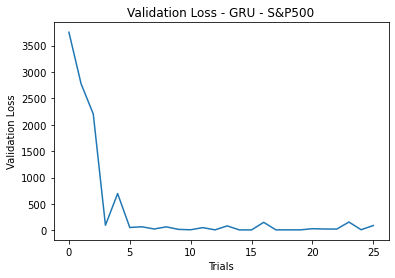

In [317]:
#GRU Validation loss

plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Trials')
plt.ylabel('Validation Loss')
plt.title('Validation Loss - GRU - S&P500')
plt.show()

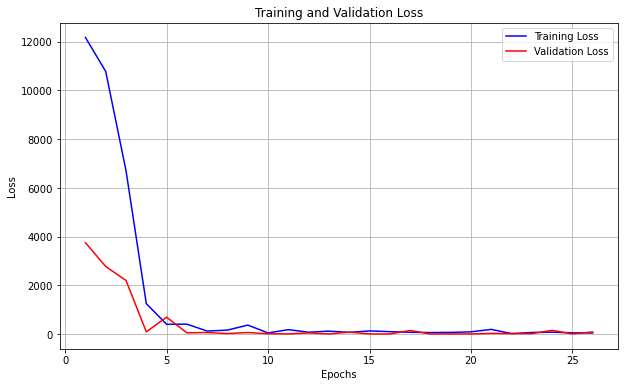

In [318]:
# Extract training and validation loss (or other metrics) from the history.
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epochs for the x-axis.
epochs = np.arange(1, len(training_loss) + 1)

# Plot the training and validation loss.
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [319]:
Y_gru_bs = model_GRU_real.predict(X_real_scaled)

1281/1281 [==============================] - 13s 10ms/step


In [320]:
# Print the scores
print("Mean Squared Error (MSE):", mean_squared_error(Y_BS, Y_gru_bs))
print("R-squared (R2):", r2_score(Y_BS, Y_gru_bs))
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_BS, Y_gru_bs))

Mean Squared Error (MSE): 11.337086716324208
R-squared (R2): 0.9993525066517605
Mean Absolute Error (MAE): 2.1356789108358254


### GRU Compare real call values

In [321]:
#Prediction against real values

# Print the scores
print("Mean Squared Error (MSE):", mean_squared_error(Y_gru_bs, Y_real))
print("R-squared (R2):", r2_score(Y_gru_bs, Y_real))
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_gru_bs, Y_real))

Mean Squared Error (MSE): 1301.4881863154005
R-squared (R2): 0.9267532015304667
Mean Absolute Error (MAE): 7.55735556431387


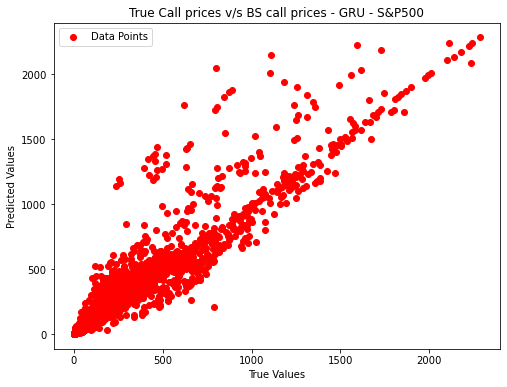

In [322]:
# Create a scatter plot to visualize True and Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(Y_real, Y_gru_bs.flatten(), color='red', label='Data Points')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Call prices v/s BS call prices - GRU - S&P500')
plt.legend()
plt.show()

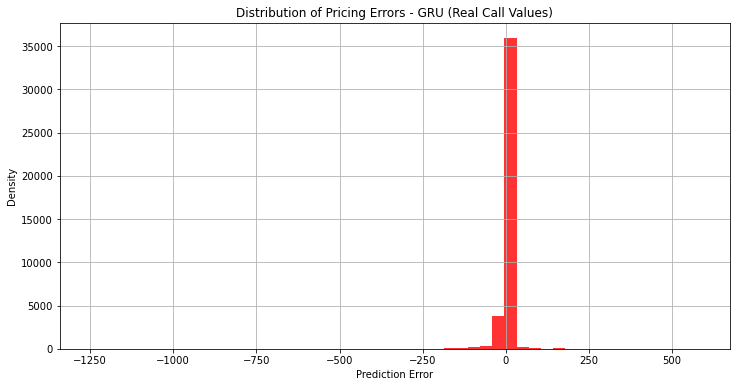

In [323]:
#Pricing error

errors_gru_bs_real = Y_real - Y_gru_bs.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_gru_bs_real, bins=50, color='red', alpha=0.8)
plt.xlabel('Prediction Error')
plt.ylabel('Density')
plt.title('Distribution of Pricing Errors - GRU (Real Call Values)')
plt.grid(True)
plt.show()

## Test on unseen dataset - 05/07/2023 Scrapped data

In [286]:
# Provide the correct path to your CSV file
csv_file_path = 'SNP.csv'

# Read the CSV file into a dataframe
Test_data = pd.read_csv(csv_file_path)

# Now you can use the imported_df dataframe in your program
Test_data.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price,Stock Name
0,101.39,80.0,0.009007,0.0598,0.2811,0.0381,21.50,MMM
1,101.39,85.0,0.009007,0.0598,0.2811,0.0381,16.35,MMM
2,101.39,89.0,0.009007,0.0598,0.2811,0.0381,12.70,MMM
3,101.39,90.0,0.009007,0.0598,0.2811,0.0381,11.35,MMM
4,101.39,92.0,0.009007,0.0598,0.2811,0.0381,8.70,MMM


In [287]:
Test_data = Test_data[Test_data['Stock Price'] > Test_data['Strike Price']] #in-the money calls
Test_data = Test_data.dropna()

In [288]:
X_TEST = Test_data.drop(columns=['Call Price','Stock Name','Dividends'])
Y_TEST = Test_data['Call Price']
X_TEST_SCALED = scaler.fit_transform(X_TEST)

In [289]:
BSM_PREDICTED = model_GRU_real.predict(X_TEST_SCALED)

650/650 [==============================] - 7s 10ms/step


In [290]:
# Print the scores
print("Mean Squared Error (MSE):", mean_squared_error(Y_TEST, BSM_PREDICTED))
print("R-squared (R2):", r2_score(Y_TEST, BSM_PREDICTED))
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_TEST, BSM_PREDICTED))

Mean Squared Error (MSE): 4350.990703058678
R-squared (R2): 0.8273934494425506
Mean Absolute Error (MAE): 17.014679180799853


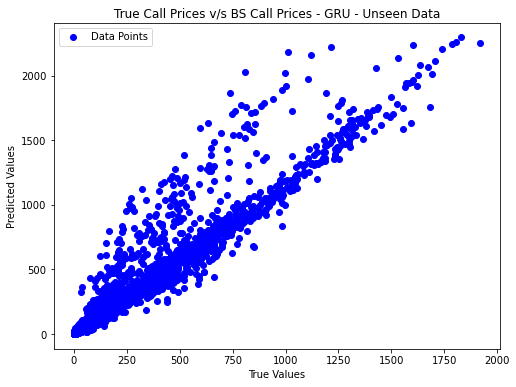

In [302]:
# Create a scatter plot to visualize True and Predicted values
plt.figure(figsize=(8, 6))
plt.scatter(Y_TEST, BSM_PREDICTED, color='blue', label='Data Points')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Call Prices v/s BS Call Prices - GRU - Unseen Data')
plt.legend()
plt.show()

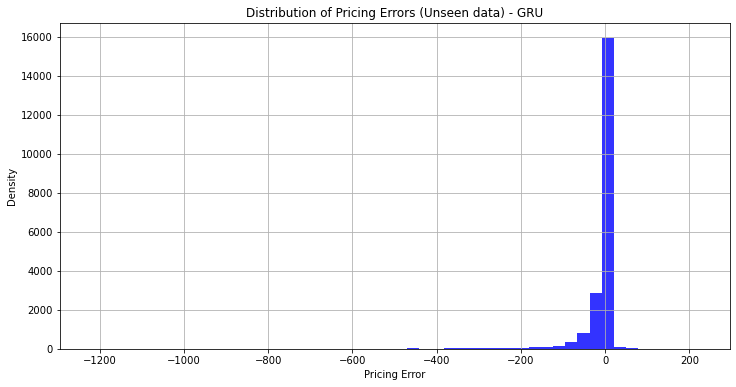

In [303]:
#Pricing error

errors_NEW = Y_TEST - BSM_PREDICTED.flatten() #Actual - Predicted values

plt.figure(figsize=(12, 6))
plt.hist(errors_NEW, bins=50, color='blue', alpha=0.8)
plt.xlabel('Pricing Error')
plt.ylabel('Density')
plt.title('Distribution of Pricing Errors (Unseen data) - GRU')
plt.grid(True)
plt.show()